In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\febi2\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Data Preprocessing
uber_2014_data = pd.read_csv("uber-raw-data-aprsep-14.csv")
uber_2014_data.rename(columns={'Date/Time': 'Pickup_datetime', 'Lat': 'Latitude', 'Lon': 'Longitude'}, inplace=True)
uber_2014_data['Pickup_datetime'] = pd.to_datetime(uber_2014_data['Pickup_datetime'])
uber_2014_data['Dispatching_base_num'] = None
uber_2014_data['Affiliated_base_num'] = None
uber_2014_data['locationID'] = None

uber_2015_data = pd.read_csv("uber-raw-data-janjune-15.csv")
uber_2015_data.rename(columns={'Pickup_date': 'Pickup_datetime'}, inplace=True)
uber_2015_data['Pickup_datetime'] = pd.to_datetime(uber_2015_data['Pickup_datetime'])
uber_2015_data['Latitude'] = None
uber_2015_data['Longitude'] = None
uber_2015_data['Base'] = None

all_data = pd.concat([uber_2014_data, uber_2015_data], ignore_index=True)
all_data.to_csv("uber_2014_2015.csv", index=False)

C:\Users\febi2\AppData\Local\Temp\ipykernel_20988\3752261874.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([uber_2014_data, uber_2015_data], ignore_index=True)


In [3]:
# Exploratory Data Analysis (EDA)
all_data['Hour'] = all_data['Pickup_datetime'].dt.hour
all_data['Day'] = all_data['Pickup_datetime'].dt.day
all_data['Month'] = all_data['Pickup_datetime'].dt.month
all_data['DayOfWeek'] = all_data['Pickup_datetime'].dt.dayofweek

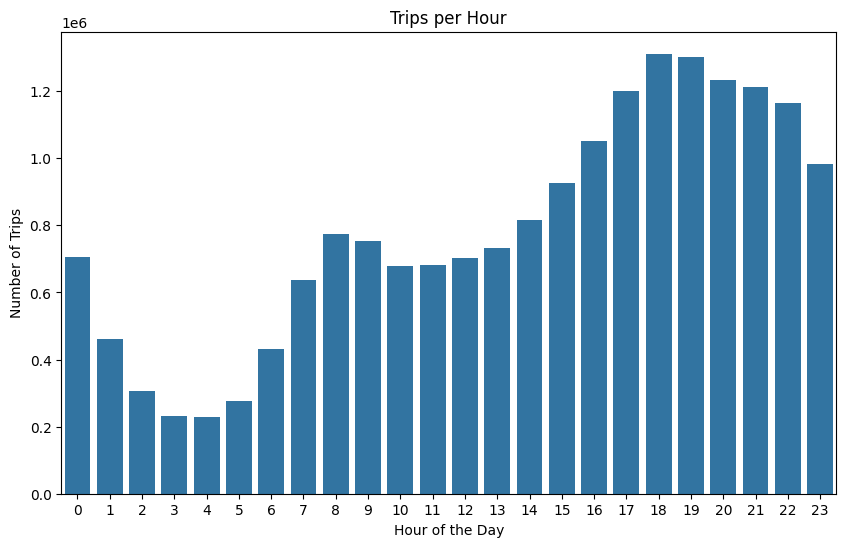

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x=all_data['Hour'])
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()

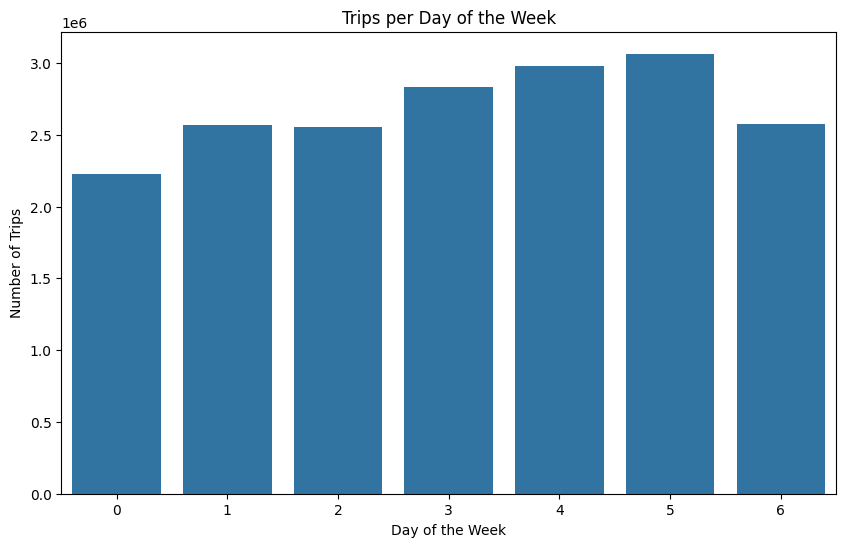

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x=all_data['DayOfWeek'])
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.show()

In [6]:
# Time-Series Decomposition
all_data.set_index('Pickup_datetime', inplace=True)
hourly_counts = all_data.resample('h').size()
result = seasonal_decompose(hourly_counts, model='additive', period=24)

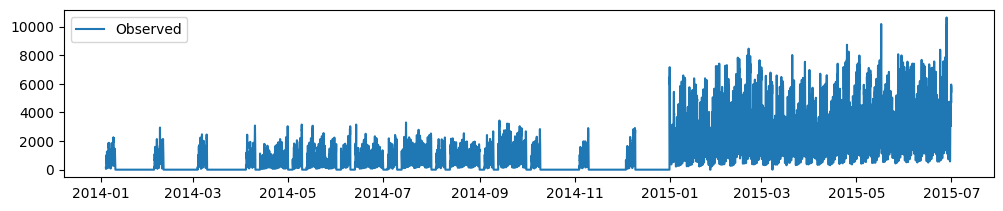

In [7]:
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()

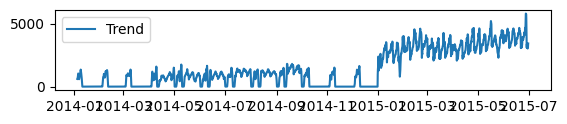

In [8]:
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

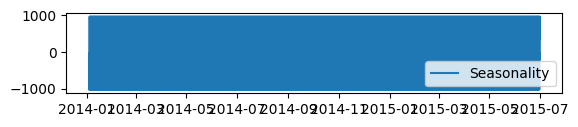

In [9]:
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()

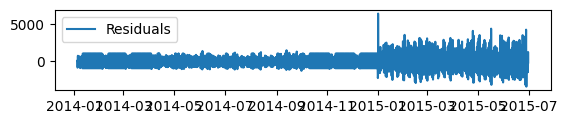

In [10]:
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()
plt.show()

In [11]:
# Feature Engineering
all_data['Is_Weekend'] = all_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
all_data['Rush_Hour'] = all_data['Hour'].apply(lambda x: 1 if (x >= 7 and x <= 9) or (x >= 16 and x <= 19) else 0)

nyc_holidays = ['2014-07-04', '2014-12-25', '2015-01-01']
all_data['Is_Holiday'] = all_data.index.strftime('%Y-%m-%d').isin(nyc_holidays).astype(int)

X_resampled = all_data.resample('h').agg({
    'Hour': 'first',
    'Day': 'first',
    'Month': 'first',
    'Is_Weekend': 'first',
    'Rush_Hour': 'first',
    'Is_Holiday': 'first'
})
X_resampled.dropna(inplace=True)
y = hourly_counts.loc[X_resampled.index]
X = X_resampled.to_numpy()
y = y.to_numpy()

print("X shape:", X.shape)  
print("y shape:", y.shape)  

X shape: (8725, 6)
y shape: (8725,)


In [12]:
# Model Building with Time-Series Split
tscv = TimeSeriesSplit(n_splits=5)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)

param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error')
gbr_search = GridSearchCV(gbr_model, param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error')

xgb_search.fit(X, y)
gbr_search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [3, 5], 'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [13]:
# Model Evaluation
y_pred_xgb = xgb_search.best_estimator_.predict(X)
y_pred_gbr = gbr_search.best_estimator_.predict(X)

print("XGBoost MAPE:", mean_absolute_percentage_error(y, y_pred_xgb))
print("Gradient Boosting MAPE:", mean_absolute_percentage_error(y, y_pred_gbr))

XGBoost MAPE: 0.7720179557800293
Gradient Boosting MAPE: 0.7066964543674995


In [14]:
# Ensemble Model (XGBoost + GBTR )
ensemble_predictions = (0.50 * y_pred_xgb) + (0.50 * y_pred_gbr)
mape_ensemble = mean_absolute_percentage_error(y, ensemble_predictions)

print("Ensemble Model MAPE (XGBoost + GBTR):", mape_ensemble)

Ensemble Model MAPE (XGBoost + GBTR): 0.7334540522262937


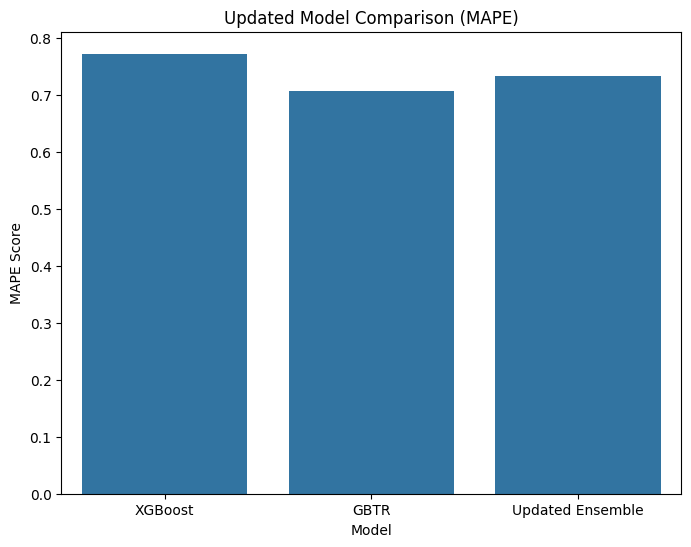

In [15]:
# Comparative Analysis
plt.figure(figsize=(8, 6))
sns.barplot(x=['XGBoost', 'GBTR', 'Updated Ensemble'], y=[
    mean_absolute_percentage_error(y, y_pred_xgb),
    mean_absolute_percentage_error(y, y_pred_gbr),
    mape_ensemble])
plt.title('Updated Model Comparison (MAPE)')
plt.xlabel('Model')
plt.ylabel('MAPE Score')
plt.show()

In [ ]:
models = {'XGBoost': xgb.XGBRegressor(), 'Gradient Boosting': GradientBoostingRegressor()}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = mape
results_df = pd.DataFrame(results.items(), columns=['Model', 'MAPE'])
print("Model Performance Comparison:")
print(results_df)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data['Pickup_datetime'], data['Target_Variable'], label='Trend Line', color='blue')
plt.axvline(x=pd.to_datetime('2015-04-01'), color='red', linestyle='--', label='Optimal Split Point')
plt.legend()
plt.title('Optimal Train-Test Split Based on Trend')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.show()

split_date = pd.to_datetime('2015-04-01')
train_data = data[data['Pickup_datetime'] < split_date]
test_data = data[data['Pickup_datetime'] >= split_date]

X_train, y_train = train_data.drop(columns=['Target_Variable']), train_data['Target_Variable']
X_test, y_test = test_data.drop(columns=['Target_Variable']), test_data['Target_Variable']

In [ ]:
# Predictions
final_models = {'XGBoost': xgb.XGBRegressor(), 'Gradient Boosting': GradientBoostingRegressor()}

for name, model in final_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{name} MAPE: {mape:.4f}")
    predictions_df = pd.DataFrame({'Actual': y_test[:10].values, 'Predicted': y_pred[:10]})
    print(f"Sample Predictions for {name}:")
    print(predictions_df)